In [1]:
%matplotlib inline
import ipfix, qof, imp
import template, graph
from loader import load_df
import pandas as pd

# init IE specs
ipfix.ie.use_iana_default()
ipfix.ie.use_5103_default()
ipfix.ie.use_specfile("qof.iespec")
ipfix.ie.use_specfile("copycat.iespec")
ipfix.types.use_integer_ipv4()

# init campaign variables
output_dir  = "plots/"
all_cids1 = ["sch1-0002-t3-f1-1", "sch1-0002-t3-f1-2", "sch1-0002-t3-f1-3"]
all_cids2 = ["sch1-0002-t3-f2-1", "sch1-0002-t3-f2-2", "sch1-0002-t3-f2-3"]
all_cids3 = ["sch1-0003-t3-f1-4", "sch1-0003-t3-f2-4"]
all_cids=all_cids1+all_cids2+all_cids3 

In [2]:
ies = ("copycatPayloadSize",
       "copycatPacketSize",
       "copycatRtt", "copycatBandwidth", 
       "copycatBdp", "copycatBurstSize", 
       "copycatBurstCount", "copycatLastBurstSize",)

tcp, udpc, udps = load_df(all_cids,
                         template.loss_udp+ies, template.loss_tcp,
                         template.index_total,
                         offset=3)

Loading tcp flows sch1-0002-t3-f1-1 ...
Loading udp client flows sch1-0002-t3-f1-1 ...
Loading udp server flows sch1-0002-t3-f1-1 ...
sch1-0002-t3-f1-1.copycatRunId += 0
Loading tcp flows sch1-0002-t3-f1-2 ...
Loading udp client flows sch1-0002-t3-f1-2 ...
Loading udp server flows sch1-0002-t3-f1-2 ...
sch1-0002-t3-f1-2.copycatRunId += 3
Loading tcp flows sch1-0002-t3-f1-3 ...
Loading udp client flows sch1-0002-t3-f1-3 ...
Loading udp server flows sch1-0002-t3-f1-3 ...
sch1-0002-t3-f1-3.copycatRunId += 6
Loading tcp flows sch1-0002-t3-f2-1 ...
Loading udp client flows sch1-0002-t3-f2-1 ...
Loading udp server flows sch1-0002-t3-f2-1 ...
sch1-0002-t3-f2-1.copycatRunId += 9
Loading tcp flows sch1-0002-t3-f2-2 ...
Loading udp client flows sch1-0002-t3-f2-2 ...
Loading udp server flows sch1-0002-t3-f2-2 ...
sch1-0002-t3-f2-2.copycatRunId += 12
Loading tcp flows sch1-0002-t3-f2-3 ...
Loading udp client flows sch1-0002-t3-f2-3 ...
Loading udp server flows sch1-0002-t3-f2-3 ...
sch1-0002-t3-f2

In [3]:
# clean df
udpc = udpc[(udpc.copycatBandwidth != 100) & (udpc.copycatRtt != 0) & (udpc.copycatBandwidth != 100000)]
udps = udps[(udps.copycatBandwidth != 100) & (udps.copycatRtt != 0) & (udps.copycatBandwidth != 100000)]

# Drop duplicates
ind = ["sourceIPv4Address", "destinationIPv4Address", "destinationTransportPort",
       "copycatRunId", "copycatFileSize", "copycatCampaignId"]

tcp = tcp.reset_index().drop_duplicates(ind).set_index(ind)
udpc = udpc.reset_index().drop_duplicates(ind).set_index(ind)
udps = udps.reset_index().drop_duplicates(ind).set_index(ind)

In [4]:
import numpy as np

tcp_loss = tcp
udp_loss = udpc

# compute loss
udp_loss["loss"] = np.abs( udps["reverseTransportOctetDeltaCount"] - udpc["reverseTransportOctetDeltaCount"])
tcp_loss["loss"] = np.abs(tcp_loss["reverseTcpSequenceLossCount"])

ind = ["sourceIPv4Address", "destinationIPv4Address", "destinationTransportPort",
       "copycatRunId", "copycatFileSize", "copycatCampaignId"]

udp_loss = udp_loss.reset_index()
tcp_loss = tcp_loss.reset_index()
udp_loss["loss"] = udp_loss["loss"] / udp_loss.copycatFileSize
tcp_loss["loss"] = tcp_loss["loss"] / tcp_loss.copycatFileSize

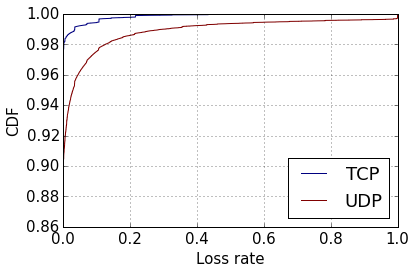

In [22]:
# Plot total loss
this_tcp = tcp_loss["loss"]
this_udp = udp_loss["loss"]
_=graph.cdf([this_tcp,this_udp], "", 
    "Loss rate", "CDF", None, 
    labels=["TCP","UDP"], font_size=15,
    legendloc=4, ylim=[0.86,1.0], xlim=[0,1.0])

In [6]:
# compute differential loss, only when there is loss
diff_loss = udp_loss[ udp_loss["loss"] > 0 ]["loss"].subtract(tcp_loss[ tcp_loss["loss"] > 0]["loss"], 
                                                              fill_value=0.0)

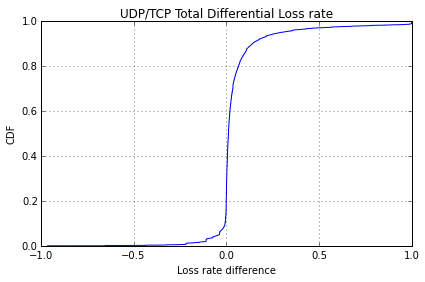

In [7]:
graph.cdf(diff_loss, "UDP/TCP Total Differential Loss rate", 
    "Loss rate difference", "CDF", None, 
    legendloc=4, xlim=[-1.0,1.0])

In [8]:
# Extract each file/block size combination separately into tcp_dfs, udp_dfs
offset  = 3
to_plot = 8
soff    = 0
eoff    = soff + offset
#
ind = ["sourceIPv4Address", "destinationIPv4Address",
       "destinationTransportPort"]
ies = ["sourceIPv4Address", "destinationIPv4Address", 
       "destinationTransportPort", "copycatFileSize",
       "copycatRunId", "loss"]

tcp_df = tcp_loss.reset_index()[ies]
udp_df = udp_loss.reset_index()[ies]

tcp_dfs = []
udp_dfs = []
for i in range(to_plot):
    this_tcp_df = tcp_df[(tcp_df.copycatRunId >= soff) & (tcp_df.copycatRunId < eoff)].set_index(ind)
    this_udp_df = udp_df[(udp_df.copycatRunId >= soff) & (udp_df.copycatRunId < eoff)].set_index(ind)
    
    tcp_dfs.append(this_tcp_df)
    udp_dfs.append(this_udp_df)
    
    soff += 3 
    eoff += 3 

In [9]:
import numpy as np
imp.reload(graph)
# plot with no averaging
max_bw      = 10e6
min_bw      = 10e2
# !!! There's a matplotlib bug here that opens 250+ fds and let em open. Run this block at the end...
this_data = []
this_labels = []
flabels = {13312: "13kB", 39936: "39kB", 399360: "390kB", 399300: "390kB", 4088832: "3.9mB"}
for this_tcp, this_udp in zip(tcp_dfs, udp_dfs):
    if this_tcp.empty:
        continue
    cid       = this_tcp.copycatRunId.value_counts().index[0]   
    if cid < 9 or (cid >= 18 and cid < 21):
        blocksize = 512
    elif (cid >= 9 and cid < 18) or (cid >= 21 and cid < 24):
        blocksize = 1460 
    else:
        print(cid)
    filesize  = this_tcp.copycatFileSize.value_counts().index[0] - 1

    this_data.append(this_tcp["loss"])
    this_data.append(this_udp["loss"])
    this_labels.append("TCP "+str(blocksize)+" "+flabels[filesize])
    this_labels.append("UDP "+str(blocksize)+" "+flabels[filesize])

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.4/dist-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "title". Falling back on "best"; valid locations are
	lower left
	upper left
	center right
	upper right
	lower center
	best
	lower right
	right
	center left
	center
	upper center

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


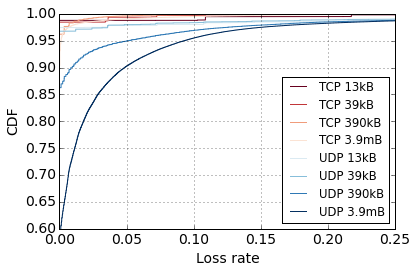

In [30]:
# merge UDP packet sizes
imp.reload(graph)
tcp1 = this_data[0].append(this_data[6])
tcp2 = this_data[2].append(this_data[8])
tcp3 = this_data[4].append(this_data[10])
tcp4 = this_data[14].append(this_data[12])

udp1 = this_data[1].append(this_data[7])
udp2 = this_data[3].append(this_data[9])
udp3 = this_data[5].append(this_data[11])
udp4 = this_data[13].append(this_data[15])


new_data=[tcp1, tcp2, tcp3, tcp4, udp1, udp2, udp3, udp4]
new_labels=['TCP 13kB','TCP 39kB', 'TCP 390kB', 'TCP 3.9mB',
            'UDP 13kB','UDP 39kB', 'UDP 390kB', 'UDP 3.9mB']

# reorder data
reorder_data = False
if reorder_data:
    new_labels = [new_labels[0], new_labels[4],
                  new_labels[1], new_labels[5],
                  new_labels[2], new_labels[6],
                  new_labels[3], new_labels[7]]

    new_data = [new_data[0], new_data[4],
                  new_data[1], new_data[5],
                  new_data[2], new_data[6],
                  new_data[3], new_data[7]]
# "plots/loss-8.pdf"
_=graph.cdf(new_data, "", "Loss rate", "CDF",  None, 
            labels=new_labels, legendoutside=True, ylim=[0.6,1.0], xlim=[0.0, 0.25])          

In [34]:
# keep only 1460b UDP packet sizes

tcp1 = this_data[6]
tcp2 = this_data[8]
tcp3 = this_data[10]
tcp4 = this_data[12]

udp1 = this_data[7]
udp2 = this_data[9]
udp3 = this_data[11]
udp4 = this_data[15]


new_data=[tcp1, tcp2, tcp3, tcp4, udp1, udp2, udp3, udp4]
new_labels=['TCP 13kB','TCP 39kB', 'TCP 390kB', 'TCP 3.9mB',
            'UDP 13kB','UDP 39kB', 'UDP 390kB', 'UDP 3.9mB']

# "plots/loss-8-2.pdf"
_=graph.cdf(new_data, "", "Loss rate", "CDF",  "plots/loss-8-2.pdf", 
            labels=new_labels, legendoutside=True, ylim=[0.7,1.0], xlim=[0.0, 0.25])          

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.4/dist-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "title". Falling back on "best"; valid locations are
	lower left
	upper left
	center right
	upper right
	lower center
	best
	lower right
	right
	center left
	center
	upper center

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


In [23]:
import pylab as p

def gridplot(a, label, cmap="RdBu", vrange=None, file=None, lim=None, title=None, ticks=None):
    p.figure() # figsize=(7,2.5)
    if vrange is None:
        p.pcolor(a, cmap=cmap)
    else:
        p.pcolor(a, cmap=cmap, vmin=vrange[0], vmax=vrange[1])
    if lim:
        p.xlim(lim)
        p.ylim(lim)
    if ticks: 
        p.xticks(ticks,("NA", "EU", "AS", "O")) 
        p.yticks(ticks,("NA", "EU", "AS", "O")) 
    p.xlabel("probe (by continents and countries)")
    p.ylabel("anchor (by continents and countries)")
    p.colorbar(label=label)
    if title:
        p.title(title)
    p.tight_layout()
    if file:
        p.savefig(file)
    
def clean_df(df, nb_nodes=220):
    """
    only keep nodes that have data for src and dst, and more than 50% flows
    sourceIPv4Address & destinationIPv4Address must be in nb_countries format (int)
    """    
    nodes=sorted(list(set(df.sourceIPv4Address.value_counts().index) 
                 & set(df.destinationIPv4Address.value_counts().index)))
    min_count = nb_nodes * .5
    
    clean_count=0
    for n in range(nb_nodes):
        if n in nodes:
            l1=len(df[df.destinationIPv4Address == n]["mean"])
            l2=len(df[df.sourceIPv4Address == n]["mean"])
            if l1 >= min_count and l2 >= min_count:
                clean_count += 1
                continue
                
        df = df[(df.destinationIPv4Address != n) & (df.sourceIPv4Address != n)]       
            
    return df, clean_count
    
def get_continent_index(df):
    """
    returns a continent index tuple    
    (0,95,158,191)
    """
    ind   = [0]
    i     = 1
    c     = 0
    nodes = sorted(list(df.sourceIPv4Address.value_counts().index))
    cont_index = sorted(list(locations.continent_nb.values()))
    
    for n in nodes:
        if i == 4:
            break
        elif n >= cont_index[i]:
            ind.append(c)
            i += 1
        c += 1
    return tuple(ind)

block 512 data 13312
tcp nodes: 203 udp nodes:199
tcp mean loss: 0.00 udp mean loss: 0.01

block 512 data 39936
tcp nodes: 200 udp nodes:196
tcp mean loss: 0.00 udp mean loss: 0.01

block 512 data 399300
tcp nodes: 199 udp nodes:194
tcp mean loss: 0.00 udp mean loss: 0.02

block 1460 data 13312
tcp nodes: 203 udp nodes:199
tcp mean loss: 0.00 udp mean loss: 0.01

block 1460 data 39936
tcp nodes: 200 udp nodes:196
tcp mean loss: 0.00 udp mean loss: 0.01

block 1460 data 399360
tcp nodes: 197 udp nodes:193
tcp mean loss: 0.00 udp mean loss: 0.01

block 512 data 4088832
tcp nodes: 181 udp nodes:166
tcp mean loss: 0.00 udp mean loss: 0.03

block 1460 data 4088832
tcp nodes: 185 udp nodes:171
tcp mean loss: 0.00 udp mean loss: 0.02



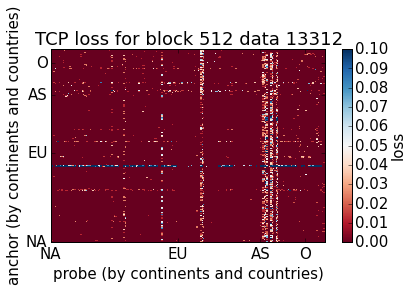

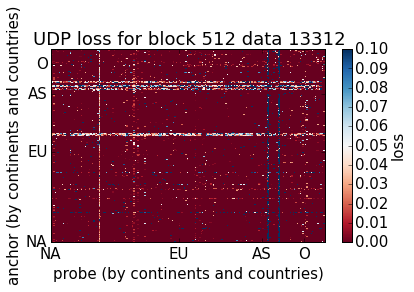

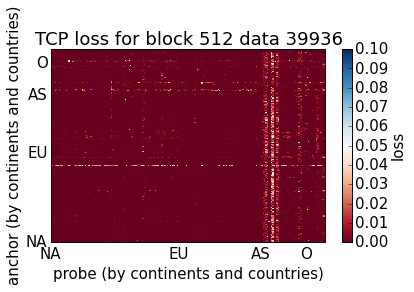

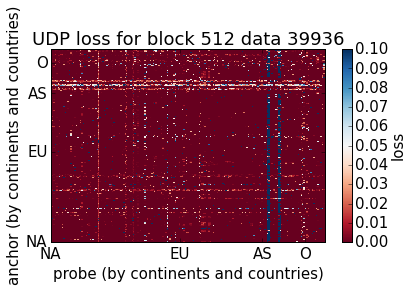

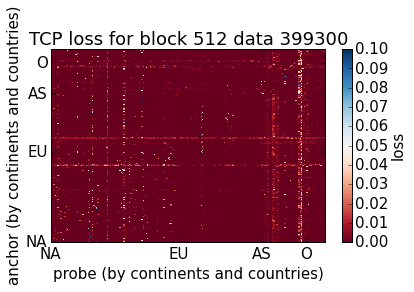

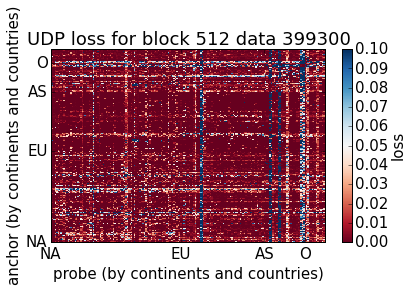

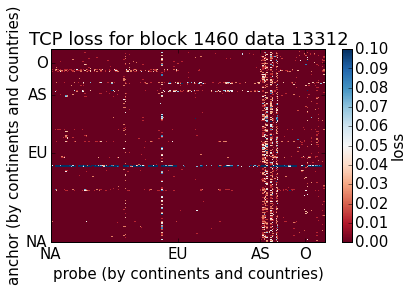

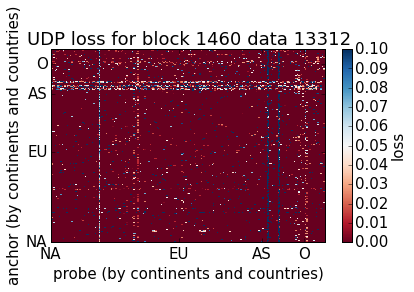

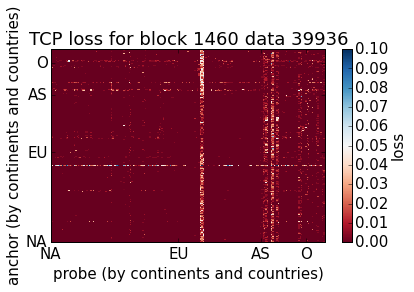

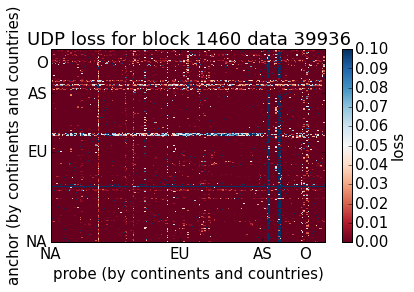

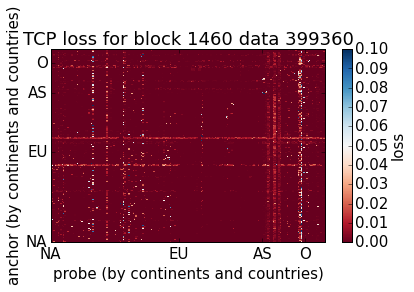

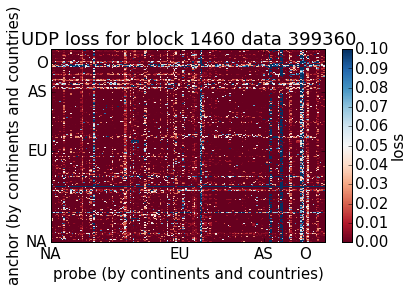

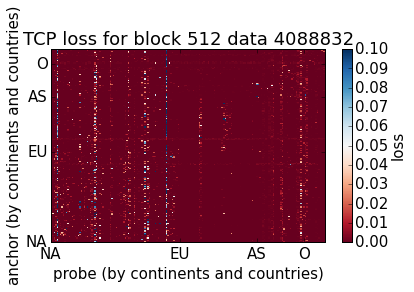

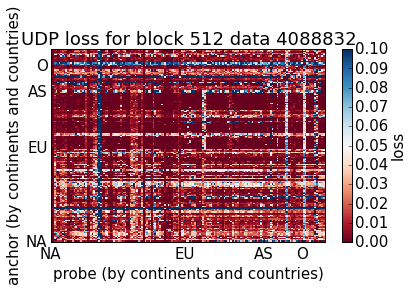

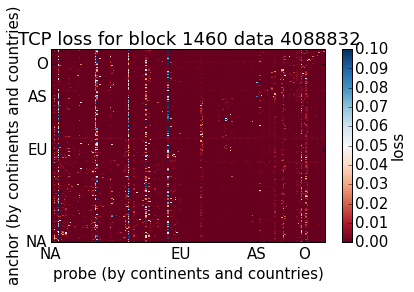

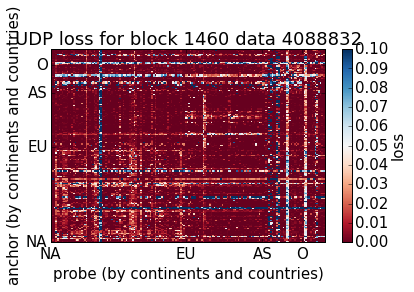

In [27]:
# loss per (filesize, blocksize, transport)-tuple heatmaps, port averaged
import config, locations
min_nodes = 140

for this_tcp, this_udp in zip(tcp_dfs, udp_dfs):
    if this_tcp.empty:
        continue
    this_tcp  = this_tcp.replace(float('inf'),0).reset_index()
    this_udp  = this_udp.replace(float('inf'),0).reset_index()
    
    # retreive filesize & blocksize
    filesize  = this_tcp.copycatFileSize.value_counts().index[0] - 1
    cid       = this_tcp.copycatRunId.value_counts().index[0]     
    if cid < 9 or (cid >= 18 and cid < 21):
        blocksize = 512
    elif (cid >= 9 and cid < 18) or (cid >= 21 and cid < 24):
        blocksize = 1460 
    else:
        print(cid)
    
    # Average RTTs
    grouped_tcp = this_tcp.groupby(["sourceIPv4Address", "destinationIPv4Address"])["loss"]
    grouped_udp = this_udp.groupby(["sourceIPv4Address", "destinationIPv4Address"])["loss"]

    this_tcp = grouped_tcp.agg([np.mean]).reset_index()
    this_udp = grouped_udp.agg([np.mean]).reset_index()

    # map node IPs to ordered ints
    this_tcp.sourceIPv4Address      = this_tcp.sourceIPv4Address.map(locations.countries_nb2)
    this_udp.sourceIPv4Address      = this_udp.sourceIPv4Address.map(locations.countries_nb2)    
    this_tcp.destinationIPv4Address = this_tcp.destinationIPv4Address.map(locations.countries_nb2)
    this_udp.destinationIPv4Address = this_udp.destinationIPv4Address.map(locations.countries_nb2)

    # remove buggy nodes
    this_tcp, tcp_dim = clean_df(this_tcp)
    this_udp, udp_dim = clean_df(this_udp)
    if udp_dim < min_nodes or tcp_dim < min_nodes:
        continue
    # get anchors continent indexes
    tcp_nodes_index = get_continent_index(this_tcp) 
    udp_nodes_index = get_continent_index(this_udp) 
    tcp_mean = this_tcp["mean"].mean()
    udp_mean = this_udp["mean"].mean()
    
    print("block "+str(blocksize)+" data "+str(filesize))
    print("tcp nodes: "+str(tcp_dim)+" udp nodes:"+str(udp_dim))
    print("tcp mean loss: %.2f udp mean loss: %.2f" % (tcp_mean, udp_mean))
    print()
    
    # re index to plot
    fill_with = 0
    this_tcp = this_tcp.reset_index(drop=True).set_index(["destinationIPv4Address", "sourceIPv4Address"]).unstack().fillna(fill_with)
    this_udp = this_udp.reset_index(drop=True).set_index(["destinationIPv4Address", "sourceIPv4Address"]).unstack().fillna(fill_with)

    #plot !
    gridplot(this_tcp, "loss", lim=[0,tcp_dim], vrange=[0, 0.1],
             title="TCP loss for block "+str(blocksize)+" data "+str(filesize), ticks=tcp_nodes_index)#, file="plots/tcp-rtt-"+str(port)+".pdf")
    gridplot(this_udp, "loss", lim=[0,udp_dim], vrange=[0, 0.1],
             title="UDP loss for block "+str(blocksize)+" data "+str(filesize), ticks=udp_nodes_index)#, file="plots/udp-rtt-"+str(port)+".pdf")


block 512 data 13312
nodes:199
mean diff loss: 0.01

block 512 data 39936
nodes:196
mean diff loss: 0.01

block 512 data 399300
nodes:194
mean diff loss: 0.01

block 1460 data 13312
nodes:199
mean diff loss: 0.01

block 1460 data 39936
nodes:196
mean diff loss: 0.01

block 1460 data 399360
nodes:193
mean diff loss: 0.01

block 512 data 4088832
nodes:166
mean diff loss: 0.02

block 1460 data 4088832
nodes:171
mean diff loss: 0.01



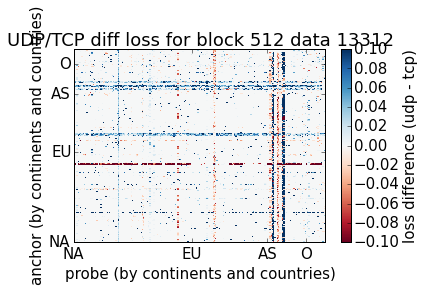

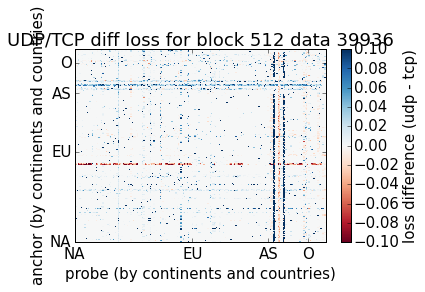

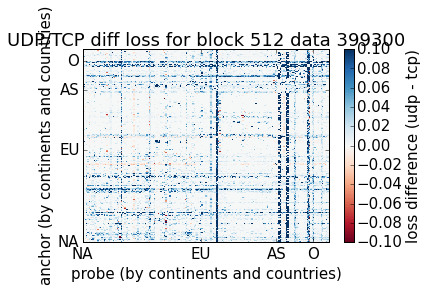

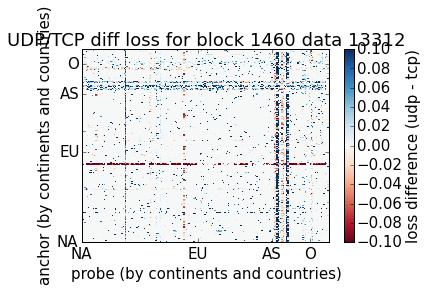

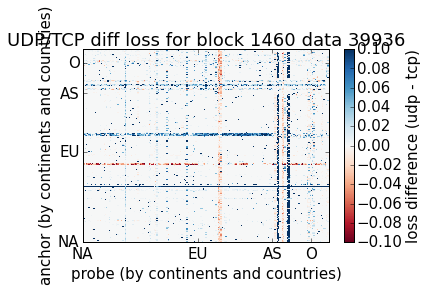

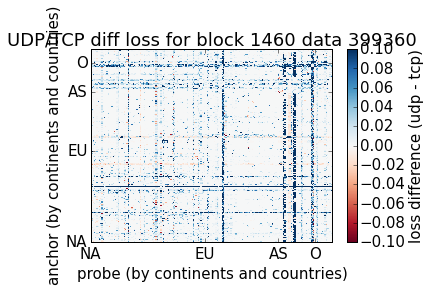

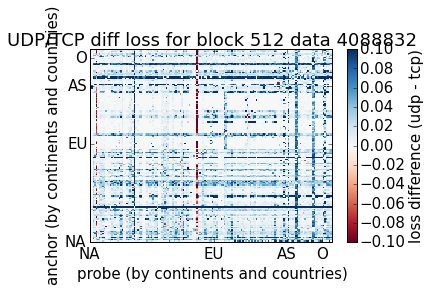

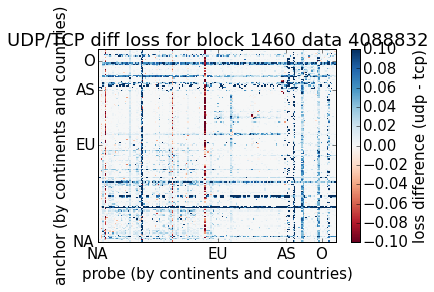

In [26]:
# loss difference per (filesize, blocksize, transport)-tuple heatmaps, port averaged
import config, locations
min_nodes = 140

for this_tcp, this_udp in zip(tcp_dfs, udp_dfs):

    this_tcp  = this_tcp.replace(float('inf'),0).reset_index()
    this_udp  = this_udp.replace(float('inf'),0).reset_index()
    
    # retreive filesize & blocksize
    filesize  = this_tcp.copycatFileSize.value_counts().index[0] - 1
    # 512:  [3; 15[U[27; 30]
    # 1460: [15; 27[U[30; 33[
    cid       = this_tcp.copycatRunId.value_counts().index[0]
    if cid < 9 or (cid >= 18 and cid < 21):
        blocksize = 512
    elif (cid >= 9 and cid < 18) or (cid >= 21 and cid < 24):
        blocksize = 1460 
    else:
        print(cid)
    
    # Average RTTs
    grouped_tcp = this_tcp.groupby(["sourceIPv4Address", "destinationIPv4Address"])["loss"]
    grouped_udp = this_udp.groupby(["sourceIPv4Address", "destinationIPv4Address"])["loss"]

    this_tcp = grouped_tcp.agg([np.mean]).reset_index()
    this_udp = grouped_udp.agg([np.mean]).reset_index()

    # map node IPs to ordered ints
    this_tcp.sourceIPv4Address      = this_tcp.sourceIPv4Address.map(locations.countries_nb2)
    this_udp.sourceIPv4Address      = this_udp.sourceIPv4Address.map(locations.countries_nb2)    
    this_tcp.destinationIPv4Address = this_tcp.destinationIPv4Address.map(locations.countries_nb2)
    this_udp.destinationIPv4Address = this_udp.destinationIPv4Address.map(locations.countries_nb2)

    # remove buggy nodes
    this_tcp, tcp_dim = clean_df(this_tcp)
    this_udp, udp_dim = clean_df(this_udp)
    if udp_dim < min_nodes or tcp_dim < min_nodes:
        continue
    
    # re index to plot
    this_tcp = this_tcp.reset_index(drop=True).set_index(["sourceIPv4Address","destinationIPv4Address"])
    this_udp = this_udp.reset_index(drop=True).set_index(["sourceIPv4Address","destinationIPv4Address"])

    # compute diff, clean & get continent indexes
    this_diff = (this_udp - this_tcp).dropna()
    diff_mean = float(this_diff.mean())
    this_diff = this_diff.reset_index()
    nodes_index = get_continent_index(this_diff)

    this_diff, diff_dim = clean_df(this_diff)
    if diff_dim < min_nodes:
        continue
    this_diff = this_diff.set_index(["destinationIPv4Address", "sourceIPv4Address"]).unstack().fillna(0)
    print("block "+str(blocksize)+" data "+str(filesize))
    print("nodes:"+str(udp_dim))
    print("mean diff loss: %.2f" % (diff_mean))
    print()

    #this_tcp
    gridplot(this_diff, "loss difference (udp - tcp)", lim=[0,diff_dim], vrange=[-0.1,0.1],
             title="UDP/TCP diff loss for block "+str(blocksize)+" data "+str(filesize), 
             ticks=nodes_index)#, file="plots/diff-rtt-"+str(port)+".pdf")